In [46]:
import torch
import cv2
import torchvision
from torchvision import models
from torchvision import transforms
import torch.optim as optim
import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Використовується: {device}')

Використовується: cuda


In [49]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomResizedCrop(size=224,scale=(0.9, 1.0),ratio=(0.95, 1.05)),
    torchvision.transforms.ColorJitter(brightness=(0.1), contrast=(0.1), saturation = (0), hue = (0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

])



In [50]:
train_dataset = torchvision.datasets.ImageFolder(
    root= "x_ray_image/train",
    transform=train_transform
)
val_dataset = torchvision.datasets.ImageFolder(
    root= "x_ray_image/val",
    transform=transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root= "x_ray_image/test",
    transform=transform
)

In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

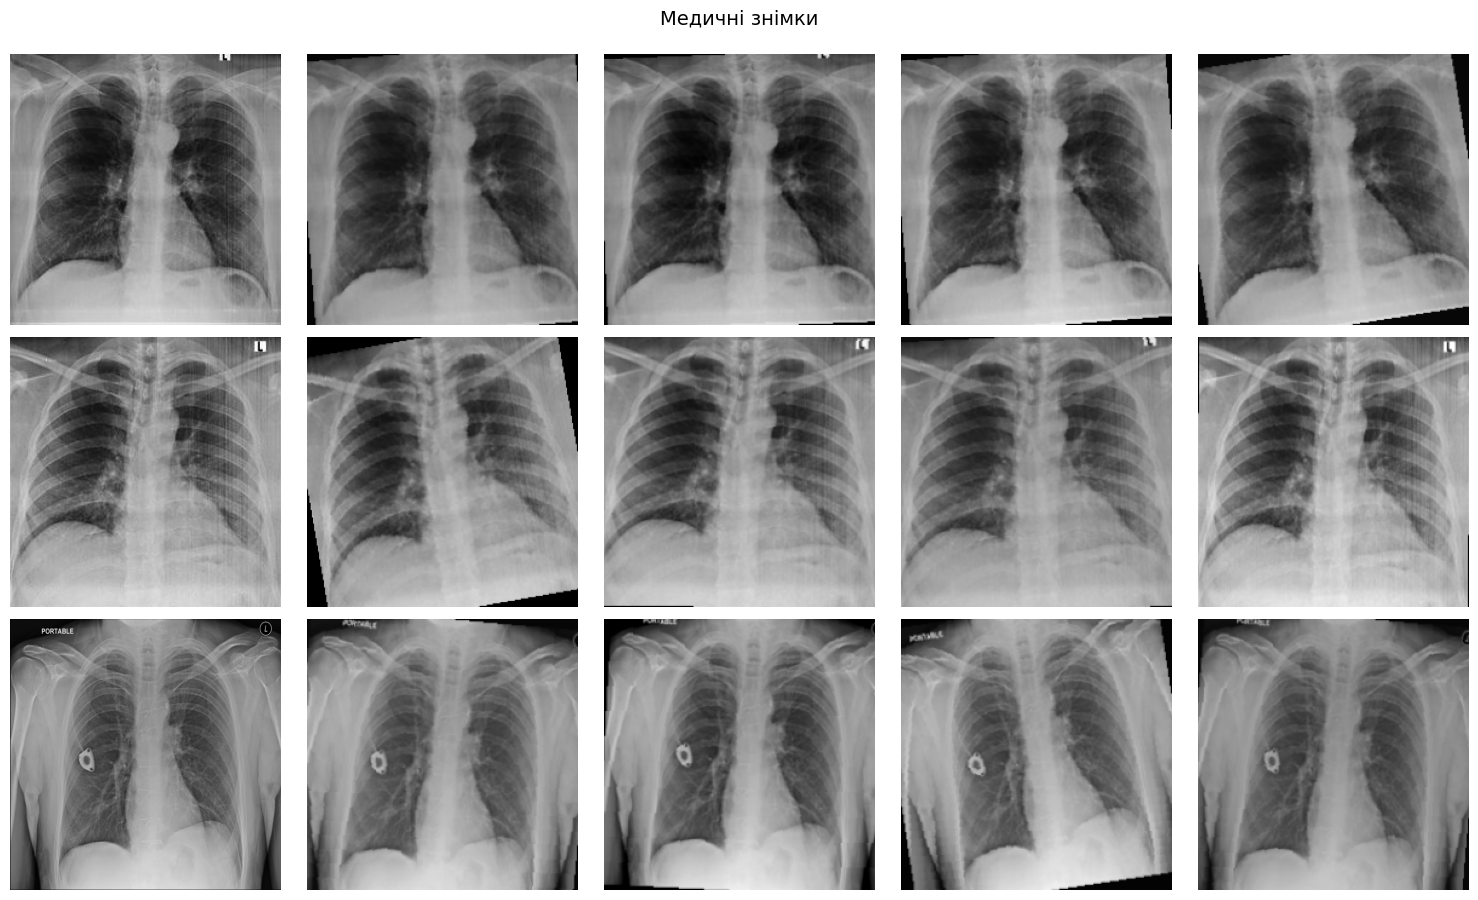

In [52]:
def denormalize(tensor):
    #Повертає зображення до вигляду 0, 1
    tensor = tensor.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # середнє значення для RGB
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)  # стандартне відхилення для  RGB
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor


fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(3):
    img_path, label = train_dataset.imgs[i]
    img = Image.open(img_path).convert('RGB')

    # Оригінал
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')

    # Аугментації
    for j in range(4):
        aug = train_transform(img)
        aug = denormalize(aug)
        aug = aug.permute(1, 2, 0).numpy()
        axes[i, j+1].imshow(aug)
        axes[i, j+1].axis('off')

plt.suptitle('Медичні знімки', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

In [53]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TransferLearningClassifier, self).__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True #Дозволяєте моделі перевчитися розморощує слої
        for param in self.model.layer3.parameters():
            param.requires_grad = True

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),# Всі негативні значення 0
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [54]:
model = TransferLearningClassifier()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) #optimizer - "вчитель" що покращує модель
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( #зменшує learning rate, коли метрика перестає покращуватись
    optimizer,
    mode='min', # слідкує за метрикою яку треба мінімізувати
    factor = 0.5, # у скільки разів зменшити learning rate
    patience = 3 #скільки епох чекати без покращення
)

In [59]:
def eval_model(loader, model, crit, device):
    model.eval()
    run_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            labels = labels.to(device)
            images = images.to(device)

            predicted = model(images)
            loss = crit(predicted, labels)

            run_loss += loss.item() * images.size(0)
            _, preds = torch.max(predicted, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)

    val_loss = run_loss / total
    val_acc = correct / total

    return val_loss, val_acc


In [60]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    train_loss = train_loss / train_total
    train_acc = train_correct / train_total


    val_loss, val_acc = eval_model(val_loader, model, criterion, device)

    scheduler.step(val_loss) #зменшує швидкість навчання


    print(f"Epoch [{epoch+1}] train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

Epoch [1/10]: 100%|███████████████████████████████████████████| 640/640 [02:40<00:00,  3.99it/s, acc=0.761, loss=0.453]


Epoch [1] train_loss=0.4527, train_acc=0.7605, val_loss=0.4224, val_acc=0.7727


Epoch [2/10]: 100%|███████████████████████████████████████████| 640/640 [02:54<00:00,  3.67it/s, acc=0.765, loss=0.433]


Epoch [2] train_loss=0.4328, train_acc=0.7653, val_loss=0.4198, val_acc=0.7719


Epoch [3/10]: 100%|████████████████████████████████████████████| 640/640 [02:47<00:00,  3.83it/s, acc=0.77, loss=0.422]


Epoch [3] train_loss=0.4220, train_acc=0.7698, val_loss=0.4048, val_acc=0.7727


Epoch [4/10]: 100%|███████████████████████████████████████████| 640/640 [03:03<00:00,  3.48it/s, acc=0.773, loss=0.413]


Epoch [4] train_loss=0.4126, train_acc=0.7731, val_loss=0.4043, val_acc=0.7684


Epoch [5/10]: 100%|███████████████████████████████████████████| 640/640 [02:58<00:00,  3.59it/s, acc=0.775, loss=0.408]


Epoch [5] train_loss=0.4079, train_acc=0.7748, val_loss=0.3955, val_acc=0.7786


Epoch [6/10]: 100%|███████████████████████████████████████████| 640/640 [02:58<00:00,  3.58it/s, acc=0.774, loss=0.408]


Epoch [6] train_loss=0.4085, train_acc=0.7743, val_loss=0.4003, val_acc=0.7723


Epoch [7/10]: 100%|███████████████████████████████████████████| 640/640 [02:53<00:00,  3.68it/s, acc=0.776, loss=0.404]


Epoch [7] train_loss=0.4040, train_acc=0.7764, val_loss=0.3982, val_acc=0.7747


Epoch [8/10]: 100%|███████████████████████████████████████████| 640/640 [02:50<00:00,  3.75it/s, acc=0.776, loss=0.402]


Epoch [8] train_loss=0.4017, train_acc=0.7757, val_loss=0.4168, val_acc=0.7743


Epoch [9/10]: 100%|███████████████████████████████████████████| 640/640 [02:37<00:00,  4.07it/s, acc=0.778, loss=0.399]


Epoch [9] train_loss=0.3992, train_acc=0.7782, val_loss=0.3964, val_acc=0.7762


Epoch [10/10]: 100%|███████████████████████████████████████████| 640/640 [02:53<00:00,  3.68it/s, acc=0.78, loss=0.391]


Epoch [10] train_loss=0.3908, train_acc=0.7799, val_loss=0.3885, val_acc=0.7727


In [61]:
test_loss, test_acc = eval_model(test_loader, model, criterion, device)
print(f" test_loss = {test_loss} test_acc = {test_acc}")


 test_loss = 0.39484560077827974 test_acc = 0.7785130400934216


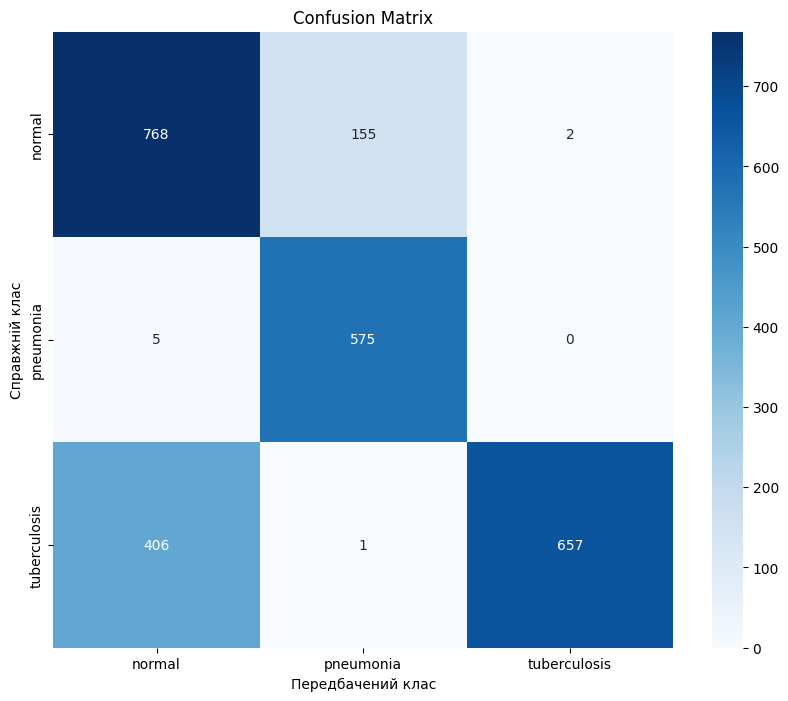

In [63]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


class_names = test_dataset.classes
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.show()

In [ ]:
хто ставить запитання той керує розмовою